Модель имитирует обработку ячеек с товарами подготовленными для отправки покупателю. Ячейка считается обработанной если все товары для отправки по одному адресу собраны в один пакет и готовы для передачи водителю экспедитору до установленного транспортной компанией времени.

**Вопросы для модели**:

*   в какое время начинать обработку?
*   сколько сотрудников выводить на работу?
*   какое условие считать необходимым для сборки товара по одному адресу - 2 наименования на адрес или 3?
*   нужны различные условия для разных дней недели - время выхода, кво сотрудников, признак необходимости объединения товаров

**Ограничения модели**:
Минимизаия доли необработанных ячеек при минимальных ресурсах склада. Ресурсами склада считаем количество работающих сотрудников и время их простоя в минутах. Простой - отсутствие работы для сотрудника по причине непоступившего с конвейера  товара для доставки по адресу. Простой возникает если вывести сотрудников на работу слишком рано, в начале складских суток, когда конвейер не отработал все задания от системы заказов.

In [ ]:
import numpy as np
import pandas as pd

#для работы с датами
from datetime import datetime, timedelta
from datetime import datetime

#для создания пустого словаря для сохранения результатов
from collections import defaultdict

#для рисовния графиков и сохранения их в блокноте
import matplotlib.pyplot as plt
%matplotlib inline

#отключение предупреждений
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#считывание данных
df = pd.read_excel('ДАННЫЕ.xlsx')
df1 = pd.read_excel('ВСЕ_АДТ.xlsx')
df = df.merge(df1, how = 'inner')
print('уникальных дней данных', df['ЗПК.Дата'].nunique())
print('строк данных', df['ЗПК.Дата'].count())

уникальных дней данных 40
строк данных 410946


Задаю параметры модели в виде списоков, чтобы посчитать результат работы склада для каждого из сочетний параметров

In [ ]:
#уровни отбора строк по коэфф потенциальному, условие НЕстрого больше уровня
Levels = [0.2, 0.3]
#время обработки одного заказа
Minutes = [10]
#количество АП на адрес доставки определяющее потребность в консолидации
Nums = [2,3]
#количество одновременно работающих сотрудников
Employees = [5,6,7,8,9,10]
#старт времени консолидации ячеек в минутах работы склада (8 часов соответствует 60 минутам)
Starts = [900, 960, 1020]

In [ ]:
#количество сочетаний параметров
Number = len(Levels) * len(Nums) * len(Employees) * len(Starts)
Number

72

Задаю вес каждого параметра, это нужно для выравнивания масштаба параметров  - чтобы все они были в единой шкале измерения

In [ ]:
#веса для ресурсов склада - определяют как будет минимизироваться целевая функция
# resources =  weight_e * Employee + weight_n * Num  + weight_l * Level + weight_p * pass_time
weight_e = 1 #вес для количества сотрудников
weight_n = 1 #вес для количества номенклатур на адрес доставки
weight_l = 10 #вес для уровня отбора коэффициента потенциального
weight_p = 1 #вес для количества часов простоя сотрудников (когда очередь не обрабатывается, тк ячейки не готовы)
weight = 100 #вес для доли обработанных ячеек,главный фактор целевой функции

In [ ]:
#отбор значений, удаленение пустых ячеек
df0 = df.copy().dropna()[['ЗПК.СхемаПродаж',
                          'Экспедиция.НомерАП',
                          'ДС.ВремяРазмещеноВЭкспедиции', #фактическое время окончания сборки
                          'Экспедиция.Ячейка',
                          'ВремяРазместитьВЭкспедицииДо', #плановое время размещения в экспедиции
                          'ВремяЗавершитьСборкуДо', #плановое время завершения сборки
                          'Адрес'
                        ]]
df0 = df0[ (df0['Экспедиция.Ячейка'] != 'До выяснения')
          & (df0['Экспедиция.Ячейка'] != 'Отказ клиента')
           & (df0['Экспедиция.Ячейка'] != 'Ошибка Конвейер')
            & (df0['ЗПК.СхемаПродаж'] != 'Электронная коммерция (agent)')
              & (df0['ЗПК.СхемаПродаж'] != 'Курьерская доставка (e-com)')
                & (df0['ЗПК.СхемаПродаж'] != 'Goods forecast') ]

df0 = df0.sort_values(by = ['ДС.ВремяРазмещеноВЭкспедиции',
                            'ЗПК.СхемаПродаж',
                            'Экспедиция.Ячейка',
                            'Адрес',
                            'ВремяЗавершитьСборкуДо',
                            'ВремяРазместитьВЭкспедицииДо',
                            'Экспедиция.НомерАП'])

Пересчитываю фактическое время в минуты работы склада, где 8 часов - первый час работы склада, 7 часов следующих суток - последний час работы склада.

In [ ]:
#ФАКТИЧЕСКОЕ ВРЕМЯ ОКОНЧАНИЯ СБОРКИ
df0['День'] = df0['ДС.ВремяРазмещеноВЭкспедиции'].dt.to_period("D")
df0['День-'] = (df0['ДС.ВремяРазмещеноВЭкспедиции'] - pd.Timedelta("1 day")).dt.to_period("D")
df0['Час'] = df0['ДС.ВремяРазмещеноВЭкспедиции'].dt.hour.astype(int)
df0['Минуты'] = df0['ДС.ВремяРазмещеноВЭкспедиции'].dt.minute.astype(int)
df0['ДеньНедели'] = df0['ДС.ВремяРазмещеноВЭкспедиции'].dt.strftime("%A")
df0['ДеньНедели-'] = df0['День-'].dt.strftime("%A")

#пересчитываю время работы склада (8 -  первый час работы склада, 7  - 24й час работы склада)
df0['ОкончаниеСборки'] = np.where(df0['Час'] >= 8, df0['ДС.ВремяРазмещеноВЭкспедиции'] - pd.Timedelta("7 hours"),
                                                   df0['ДС.ВремяРазмещеноВЭкспедиции'] + pd.Timedelta("17 hours"))

#также нужна замена дня и дня недели если фактическое время раньше 8, тк это окончание прошлых суток работы склада
df0['ДеньCклада'] = np.where(df0['Час'] >= 8, df0['День'], df0['День-'])
df0['ДеньНеделиCклада'] = np.where(df0['Час'] >= 8, df0['ДеньНедели'], df0['ДеньНедели-'])
df0['ЧасСклада'] = np.where(df0['Час'] >= 8, df0['Час'] - 7, df0['Час'] + 17)
df0['ФактОкончанияСборки'] = df0['ЧасСклада'] * 60 + df0['Минуты']


#ПЛАНОВОЕ ВРЕМЯ ОКОНЧАНИЯ СБОРКИ
df0['ПланСборкиЧас'] = df0['ВремяЗавершитьСборкуДо'].astype(str).str.split(':').str[0].astype (int)
df0['ПланСборкиМин'] = df0['ВремяЗавершитьСборкуДо'].astype(str).str.split(':').str[1].astype (int)

#перевожу время размещения в экспедицию в складское время по той же схеме
df0['ПланСборкиЧас'] = np.where(df0['ПланСборкиЧас'] >= 8,
                                df0['ПланСборкиЧас'] - 7,
                                df0['ПланСборкиЧас'] + 17)
#если попадаем на время работы склада с 1 по 5 час, то + 24 часа тк это следующие сутки
df0['ПланСборкиЧас'] = np.where((df0['ПланСборкиЧас'] >= 1) & (df0['ПланСборкиЧас'] <= 5),
                                 df0['ПланСборкиЧас'] + 24,
                                 df0['ПланСборкиЧас'])
df0['ПланОкончанияСборки'] = df0['ПланСборкиЧас'] * 60 + df0['ПланСборкиМин']



#ПЛАНОВОЕ ВРЕМЯ РАЗМЕЩЕНИЯ В ЭКСЕДИЦИЮ
df0['ПланЭкспедицииЧас'] = df0['ВремяРазместитьВЭкспедицииДо'].astype(str).str.split(':').str[0].astype (int)
df0['ПланЭкспедицииМин'] = df0['ВремяРазместитьВЭкспедицииДо'].astype(str).str.split(':').str[1].astype (int)

#перевожу время размещения в экспедицию в складское время по той же схеме
df0['ПланЭкспедицииЧас'] = np.where(df0['ПланЭкспедицииЧас'] >= 8,
                                     df0['ПланЭкспедицииЧас'] - 7,
                                     df0['ПланЭкспедицииЧас'] + 17)
#если попадаем на время работы склада с 1 по 5 час, то + 24 часа тк это следующие сутки
df0['ПланЭкспедицииЧас'] = np.where((df0['ПланЭкспедицииЧас'] >= 1) & (df0['ПланЭкспедицииЧас'] <= 5),
                                     df0['ПланЭкспедицииЧас'] + 24,
                                     df0['ПланЭкспедицииЧас'])
df0['ПланЭкспедиция'] = df0['ПланЭкспедицииЧас'] * 60 + df0['ПланЭкспедицииМин']

In [ ]:
#оставляю только нужные ячейки
actual_columns = ['ДеньCклада',
                  'ДеньНеделиCклада',
                  'ЗПК.СхемаПродаж',
                  'Экспедиция.Ячейка',
                  'Адрес',
                  'Экспедиция.НомерАП',
                  'ФактОкончанияСборки',
                  'ПланОкончанияСборки',
                  'ПланЭкспедиция']


sorted_columns = ['ДеньCклада',
                  'ЗПК.СхемаПродаж',
                  'Экспедиция.Ячейка',
                  'ФактОкончанияСборки',
                  'Адрес'
                  ]

df0 = df0[actual_columns].sort_values(by = sorted_columns).reset_index(drop = True)

#Как распределено время окончания сборки адреса? это нужно для выбора правильного старта начала консолидации
df0['ФактОкончанияСборки'].describe()

count    247754.000000
mean        939.432045
std         250.392873
min          60.000000
25%         756.000000
50%         936.000000
75%        1132.000000
max        1499.000000
Name: ФактОкончанияСборки, dtype: float64

In [ ]:
#убираю субботу, тк в этот день нет активности
df0 = df0[(df0['ДеньНеделиCклада'] != 'Saturday')]

#меняю английские названия на русские
week_map = {'Monday':'Понедельник',
            'Tuesday': 'Вторник',
            'Wednesday': 'Среда',
            'Thursday': 'Четверг',
            'Friday': 'Пятница',
            'Saturday':'Суббота',
            'Sunday':'Воскресенье'}

df0['ДеньНеделиCклада'] = df0['ДеньНеделиCклада'].replace(week_map)

In [ ]:
#функция считает коэффициенты по критерию консолидации N; затем отбирает сроки на основе условия коэфф >= level
def coefficient(df, Num, Level):

    #наборы столбцов для группировки
    columns_adress = ['ЗПК.СхемаПродаж', 'ДеньCклада', 'Экспедиция.Ячейка','Адрес']
    columns = ['ЗПК.СхемаПродаж','ДеньCклада', 'Экспедиция.Ячейка']

    df = df.copy().sort_values(by = columns_adress).reset_index(drop = True)

    #считаю количество АП в ячейке на адрес доставки
    df['КвоАП_Адрес'] = df.groupby(columns_adress)['Экспедиция.НомерАП'].transform('count')
    #считаю количество АП в ячейке всего ( на все адреса доставки)
    df['КвоАП_Ячейка'] = df.groupby(columns)['Экспедиция.НомерАП'].transform('count')

    df['ПризнакКонсолидации'] = np.where(df['КвоАП_Адрес'] >= Num, 1, 0)
    #меняю расчет количества АП в Ячейке накопительно, исключая случаи когда консолидаия не нужна
    df['АПКонсолидируемые'] = df.groupby(columns_adress)['ПризнакКонсолидации'].transform('cumsum')

    #считаю все подлежащие консолидаии адреса в этой ячейке (суммарно)
    df['АПКонсолидируемыеВсе'] = df.groupby(columns)['АПКонсолидируемые'].transform('max')

    #считаю фактический коэф консолидаии
    df['Коэф_факт'] = df['АПКонсолидируемые'] / df['КвоАП_Ячейка']

    #считаю потенциальный коэф консолидации
    df['Коэф_пот'] = df['АПКонсолидируемыеВсе'] / df['КвоАП_Ячейка']

    #Базовые КРИТЕРИИ ОТБОРА по коэффициентам и их равенству
    df = df[(df['Коэф_пот'] >= Level ) & (df['Коэф_пот'] == df['Коэф_факт']) ]

    return df

In [ ]:
#функция строит очередь для ячеек внутри дня
def queue(df, M):
    #наборы столбцов для группировки
    columns_adress = ['ЗПК.СхемаПродаж', 'ДеньCклада', 'Экспедиция.Ячейка','Адрес']

    #делаю сводную таблицу для очереди
    df_queue = df.groupby(columns_adress + ['ДеньНеделиCклада']).agg({'ФактОкончанияСборки' : ['max'], #время окончания сборки адреса
                                                                   'ПланОкончанияСборки' : ['max'], #плановое время окончания сборки
                                                                   'ПланЭкспедиция' : ['max'], #плановое время экспедиции
                                                                   'КвоАП_Адрес' : ['max'], #отражает наполненность адреса АП                                                                                                                                             '
                                                                  }).reset_index()

    df_queue.columns = df_queue.columns.droplevel(1)
    #переименовываю ячейки в сводной таблице
    df_queue.rename(columns = {'ФактОкончанияСборки' : 'ОкончаниеСборкиАдреса',#для критерия выполнимости
                               'ПланОкончанияСборки': 'ПланСборкиАдреса', #для формирования очереди
                               'ПланЭкспедиция' : 'ЭкспедицияАдреса',#для формирования очереди
                               'КвоАП_Адрес':'МаксАП_Адрес', #для формирования очереди
                               }, inplace = True ) #для формирования очереди

    #СОРТИРОВКА ВНУТРИ ДНЯ ПО РАСЧИТАННЫМ ПАРАМЕТРАМ
    sort_columns = ['ПланСборкиАдреса', #это время система знает уже на 3 час работы склада (10.00 актуального времени)
                    'ЭкспедицияАдреса', #это время тоже заранее известно
                    'ЗПК.СхемаПродаж', #для группы важно
                    'МаксАП_Адрес', #кво АП на адрес доставки известно после формирования заказа
                    'ОкончаниеСборкиАдреса', #дополнительный критерий для 'умной' очереди
                   ]
    #в группах по ДнюСклада сортирую строки с номерами ячейки
    grouped_df = df_queue.groupby(['ДеньCклада', 'ДеньНеделиCклада'])
    #пустой фрейм для складирования отсортированных дней
    df_res = pd.DataFrame()
    for group_name, group_data in grouped_df:

       y = group_data.sort_values(by = sort_columns, ascending = (True, True, True, False, True))
       df_res = pd.concat([df_res, y], ignore_index = True)

    return df_res

In [ ]:
#функция имитирует обработку очереди Q сотрудниками и выдает время окончания ОДНОГО цикла обработки и наличие простоя в работе очереди
#очередь перестараивается внутри функии при каждом вызове
#start - время начала консолидации
#time - время завершения итерации
def processing(df, start, Q):

    count_pass = 0  #подсчет количества простоев

    df = df[(df['ЯчейкаОбработана'] == 0)] #беру в работу только необработанные ячейки
    df['ОчередьЯчейки'] = df.groupby(['ДеньCклада', 'ДеньНеделиCклада']).transform('cumcount')
    df['ОчередьЯчейки'] = df['ОчередьЯчейки']+1 #подсчет очереди ячейки

    df['ОчередьЯчейки'] = np.ceil(df['ОчередьЯчейки']/Q) #пересчитываю очередь в зависимости от количества сотрудников

    time = start #пока не было консолидации, время начала = время конца
    for i in range (0, len(df['Экспедиция.Ячейка'])):

        #условие на консолидацию - ячейка собрана И успеваем обработать до экспедиции
        if (df['ОкончаниеСборкиАдреса'].iloc[i] <= time) & (df['ЭкспедицияАдреса'].iloc[i] >= time + 10):

                  #считаю время начала обработки ячейки в зависимости от количества работающих сотрудников и очереди
                  df['НачалоКонсолидации'].iloc[i] = start + (df['ОчередьЯчейки'].iloc[i] - 1) * 10
                  #считаю время окончания обработки ячейки в зависимости от количества работающих сотрудников и очереди
                  df['КонецКонсолидации'].iloc[i] = start + df['ОчередьЯчейки'].iloc[i] * 10
                  #маркер обработанной ячейки
                  df['ЯчейкаОбработана'].iloc[i] = 1
                  #текущее время -  окончание обработки очередной ячейки
                  time =  df['КонецКонсолидации'].iloc[i]
        else:
                  #если не можем сейчас обработать эту ячейку, то сдвигаем очередь после этой ячейки на шаг вперед
                  df['ОчередьЯчейки'][i:] = df['ОчередьЯчейки'][i:].shift()
                  #текущую очередь зануляем
                  df['ОчередьЯчейки'].iloc[i] = 0


    q_end =  df['ЯчейкаОбработана'].sum() #кво обработанных ячеек в конце итерации

    #если за итерацию нет увеличения количества обработанных ячеек, то продвигаем текущее время на шаг вперед и засчитываем простой
    if q_end == 0:

       time += 10
       count_pass += 1

    return  df, time, count_pass, q_end

In [ ]:
#функция Обработатывает очередь каждого дня и считает затраченные ресурсы склада для параметров
# Minute - время обработки одной ячейки в минутах
# Employee - количество сотрудников работающих на складе
# Num - количество товаров на один адрес доставки, определяющее необходимость объединения товаров в один пакет - 2 или 3
# Level - уровень коэффииента объединения для ячейки - отношение текущего количества адресов доставки в ячейке  к общему количеству, которое соберется за весь день (его система знает заранее) - 0.2 или 0.3
# Start - время начала работ в минутах складских  суток

def model(df_res, Minute, Employee, Num, Level, Start):
    #пустой словарь для результатов
    RESULT = defaultdict(list)

    #ОБРАБОТКА ОЧЕРЕДИ внутри каждого дня, с учетом дня недели
    grouped_df = df_res.groupby(['ДеньCклада','ДеньНеделиCклада'])

    for group_name, group_data in grouped_df:

        y = group_data.reset_index(drop = True)

        #удаляю дубликаты ячеек сохраняя первый экземлпяр
        y = y[ ~ y['Экспедиция.Ячейка'].duplicated(keep='first')].copy()

        #вспомогательные ячейки для расчетов
        y['ЯчейкаОбработана'] = 0
        y['НачалоКонсолидации'] = 0
        y['КонецКонсолидации'] = 0

        #последнее время сдачи в экспедиию -   время последней в очереди строки
        end = y['ЭкспедицияАдреса'].tail(1).values[0]


        #ОБРАБОТКА ОЧЕРЕДИ ОДНОГО ДНЯ - пока не пришло время сдачи в экспедицию, делаю итерации обработки очереди
        i = 0 #номер итерации обработки очереди
        count_pass = 0 #счетчик простоев очереди
        processed = 0 #счетчик обработанных ячеек

        local_time = Start #время завершения итерации, первое значение совпадает с глобальным стартом
        y_current = y.copy()

        while local_time < end:
              i += 1
              y_current = processing(y_current, local_time, Employee)[0]
              local_time = y_current[1]
              count_pass += y_current[2]
              processed +=  y_current[3]



        #считаю количество необработанных ячеек
        negative_count = len(y) - processed
        #считаю долю необработанных ячеек
        remainder = round( negative_count/len(y) * 100, 2)
        print('Завершена обработка дня', group_name)

        #считаю потраченные ресурсы для текущего сочетания параметров
        pass_time = round(count_pass * Minute / 60, 2) #время простоя в часах, суммарное на всех сотрудников
        resources =  weight_e * Employee + weight_n * Num  + weight_l * Level + weight_p * pass_time #ресурсы склада как взвешеннная сумма параметров

        RESULT['СтартКонсолидации'].append(Start)
        RESULT['ВремяОбработки'].append(Minute)
        RESULT['КоличествоСотрудников'].append(Employee)
        RESULT['ПотребностьКонсолидации'].append(Num)
        RESULT['УровеньКоэффициента'].append(Level)
        RESULT['День'].append(group_name[0])
        RESULT['ДеньНедели'].append(group_name[1])
        RESULT['ОбработаноЯчеек'].append(processed)
        RESULT['НеОбработаноЯчеек'].append(negative_count)
        RESULT['ДоляНеобработанныхЯчеек'].append(remainder)
        RESULT['ЧасыПростояСотрудников'].append(pass_time)
        RESULT['РесурсыСклада'].append(resources)

    return (RESULT)

In [ ]:
#Просчитываю модель по сетке параметров
#Пустой фрейм для записи результатов
df_model = pd.DataFrame()

count_process = 0

for Level in Levels:
    for Num in Nums:
        for Minute in Minutes:
            for Employee in Employees:
                for Start in Starts:


                    #для текущих параметров считаю коэффициенты консолидации
                    #отбираю строки которые пойдут в консолидацию
                    df1 = coefficient(df0, Num, Level)

                    #присваиваю ячейкам номер очереди внтури каждого дня
                    df2 = queue(df1,Minute)[0]

                    #запускаю обработку очереди и записываю ежедневные результаты
                    result = model(df2, Minute, Employee, Num, Level, Start )

                    df_res = pd.DataFrame(result)
                    df_model = pd.concat([df_model,df_res], ignore_index = True)
                    count_process += 1
                    print('Готовность', round(count_process/Number,2), '%')


Завершена обработка дня (Period('2024-06-02', 'D'), 'Воскресенье')
Завершена обработка дня (Period('2024-06-03', 'D'), 'Понедельник')
Завершена обработка дня (Period('2024-06-04', 'D'), 'Вторник')
Завершена обработка дня (Period('2024-06-05', 'D'), 'Среда')
Завершена обработка дня (Period('2024-06-06', 'D'), 'Четверг')
Завершена обработка дня (Period('2024-06-07', 'D'), 'Пятница')
Завершена обработка дня (Period('2024-06-09', 'D'), 'Воскресенье')
Завершена обработка дня (Period('2024-06-10', 'D'), 'Понедельник')
Завершена обработка дня (Period('2024-06-11', 'D'), 'Вторник')
Завершена обработка дня (Period('2024-06-12', 'D'), 'Среда')
Завершена обработка дня (Period('2024-06-13', 'D'), 'Четверг')
Завершена обработка дня (Period('2024-06-14', 'D'), 'Пятница')
Завершена обработка дня (Period('2024-06-16', 'D'), 'Воскресенье')
Завершена обработка дня (Period('2024-06-17', 'D'), 'Понедельник')
Завершена обработка дня (Period('2024-06-18', 'D'), 'Вторник')
Завершена обработка дня (Period('20

Какая эффективность алгоритма по разным сочетаниям параметров? Есть из чего выбирать параметры? Вижу что в 18% случаев останутся необработанными от 15 до 20 % ячеек

In [ ]:
#Эффективность алгоритма в целом?
#объявляю интервалы долей необработанных ячеек
interval_range = pd.interval_range(start=0,
                                   freq=5,
                                   end=100,
                                   closed='left')

df_model['ИнтервалДоли'] = pd.cut(df_model['ДоляНеобработанныхЯчеек'],
                                  bins=interval_range,
                                  labels=[1,2,3])
#сколько строк в % от общего количества приходятся на каждый из интервалов?
df_model['ИнтервалДоли'].value_counts(normalize = True)

ИнтервалДоли
[15, 20)     0.181481
[10, 15)     0.171759
[20, 25)     0.143056
[25, 30)     0.109722
[5, 10)      0.079167
[30, 35)     0.070370
[95, 100)    0.063426
[35, 40)     0.048148
[40, 45)     0.030556
[50, 55)     0.015741
[90, 95)     0.014815
[45, 50)     0.014352
[85, 90)     0.011574
[55, 60)     0.008796
[70, 75)     0.007407
[75, 80)     0.006944
[80, 85)     0.006944
[60, 65)     0.006481
[65, 70)     0.006481
[0, 5)       0.002778
Name: proportion, dtype: float64

Графическое представление распределения долей необработанных ячеек по дням недели в зависимости от выбранных параметров. Видим что в воскресенье максимальная доля необработанных ячеек

<Axes: xlabel='ДоляНеобработанныхЯчеек', ylabel='Count'>

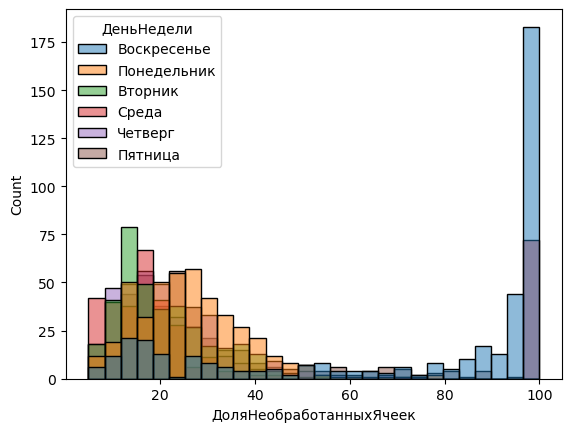

In [ ]:
import seaborn as sns
sns.histplot(data = df_model, x = "ДоляНеобработанныхЯчеек", hue="ДеньНедели")

Необходимо сделать выбор параметров для каждого дня недели. Вручную это сделать трудно, т.к. для каждой даты посчитано по 72 варианта результата в зависимости от выбранных параметров.

Усредняю по дням недели количество обработанных и необработанных ячеек, расчитываю потраченные ресурсы склада для этих усредненных значений и сортирую по возрастанию функии потерь. В первых строках для каждого дня недели будут искомые параметры работы склада.

Функия потерь  = доля необработанных ячеек * 100 + взвешенная сумма потраченных ресурсов склада, ее я минимизирую, выбирая параметры.

In [ ]:
# #для каждого уникального набора параметров усредняю результаты алгоритма обработки очереди по дням недели
params = ['СтартКонсолидации',
          'ВремяОбработки',
          'КоличествоСотрудников',
          'ПотребностьКонсолидации',
          'УровеньКоэффициента',
          'ДеньНедели']

df_week_days = df_model.groupby(params).agg({'ОбработаноЯчеек':'mean',
                                              'НеОбработаноЯчеек':'mean',
                                              'ЧасыПростояСотрудников' : 'mean'
                                             }).reset_index().round(0)

#для усредненных результатов работы очереди пересчитываю долю необработанных ячеек и ресурсы склада
df_week_days['ВсегоЯчеек'] = df_week_days['НеОбработаноЯчеек'] + df_week_days['ОбработаноЯчеек']
df_week_days['ДоляНеобработанныхЯчеек'] = df_week_days['НеОбработаноЯчеек']/df_week_days['ВсегоЯчеек']
df_week_days['РесурсыСклада'] = df_week_days['КоличествоСотрудников'] * weight_e + \
                                df_week_days['ПотребностьКонсолидации'] * weight_n + \
                                df_week_days['УровеньКоэффициента'] * weight_l + \
                                df_week_days['ЧасыПростояСотрудников'] * weight_p
df_week_days['ЦелеваяФункция'] = df_week_days['ДоляНеобработанныхЯчеек'] * weight + df_week_days['РесурсыСклада']

In [ ]:
#для каждого дня недели будет одинаковое кво вариантов подсчета - по числу вариантов уникальных сочетаний параметров
df_week_days['ДеньНедели'].value_counts()

ДеньНедели
Воскресенье    72
Вторник        72
Понедельник    72
Пятница        72
Среда          72
Четверг        72
Name: count, dtype: int64

Вывожу оптимальные параметры работы склада для каждого дня недели, кроме субботы - в этот день нет отгрузок, смотри иссследование

In [ ]:
df_best_params = df_week_days.sort_values(['ЦелеваяФункция'],ascending= True ). groupby('ДеньНедели').head(1)
df_best_params

,СтартКонсолидации,ВремяОбработки,КоличествоСотрудников,ПотребностьКонсолидации,УровеньКоэффициента,ДеньНедели,ОбработаноЯчеек,НеОбработаноЯчеек,ЧасыПростояСотрудников,ВсегоЯчеек,ДоляНеобработанныхЯчеек,РесурсыСклада,ЦелеваяФункция
160,960,10,5,3,2.0,Среда,158.0,23.0,6.0,181.0,0.127072,34.0,46.707182
37,900,10,6,3,2.0,Вторник,155.0,21.0,6.0,176.0,0.119318,35.0,46.931818
41,900,10,6,3,2.0,Четверг,168.0,22.0,7.0,190.0,0.115789,36.0,47.578947
14,900,10,5,3,2.0,Понедельник,128.0,25.0,7.0,153.0,0.163399,35.0,51.339869
87,900,10,8,3,2.0,Пятница,153.0,31.0,7.0,184.0,0.168478,38.0,54.847826
426,1020,10,10,3,3.0,Воскресенье,40.0,24.0,8.0,64.0,0.375000,51.0,88.500000


Видим что для воскресенья недостаточно даже 10 человек, все равно остаются необработанными 37% ячеек. Почему? В этот день происходит отправка товара по агентской схеме, где на один адрес доставвки приходится от 10 до 100 товаров, смотри исследование данных. Поэтому необходимо в агентском договоре предусмотреть отсутствие с нашей стороны обязательств объединять товар по адресам - у нас недостаточно ресурсов для этого.

Для остальных дней недели получаем искомые параметры работы склада - количество сотрудников и время их выхода. Количество необработанных ячеек будет от 12% до 17%.

 Так как время простоя в часах - суммарное на всех сотрудников, то стремиться к его уменьшению не стоит, это нереалистично, один час перерыва за смену должен быть у каждого сотрудника.

 Если мы хотим свести к нулю количество необработанных ячеек, то необходимо изменить настройку конвейера, чтобы медиана времени готовности товара была ранее 900 минут складских суток.